Source:  
https://www.kaggle.com/code/vinayakshanawad/random-forest-with-bootstrap-sampling-for-beginner 
https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic 

Domain:  
Breast Cancer

Context: 
Anaylsing signs of breast cancer diagnostic dataset to identify patterns and relationships between various diagnostic features and the signs of diagnosis when it comes with malignant or benign cells, which determines whether the abnormal cells grow cancerous faster or slower.

Additional Variable Information 
1) ID number
2) Diagnosis (M = malignant, B = benign) 
3-32)

Ten real-valued features are computed for each cell nucleus:

	a) radius (mean of distances from center to points on the perimeter)
	b) texture (standard deviation of gray-scale values)
	c) perimeter
	d) area
	e) smoothness (local variation in radius lengths)
	f) compactness (perimeter^2 / area - 1.0)
	g) concavity (severity of concave portions of the contour)
	h) concave points (number of concave portions of the contour)
	i) symmetry 
	j) fractal dimension ("coastline approximation" - 1)

Objective: 
Modeling possiblities for signs of increase in breast cancer using Machine Learning

In [1]:
import pandas as pd  # type: ignore
import numpy as np  # type: ignore 
from sklearn import preprocessing # type: ignore  
from sklearn import metrics 
from sklearn.pipeline import Pipeline 
import warnings


In [2]:
dataset_directory = "wdbc.csv" 
dataset = pd.read_csv(dataset_directory)

In [3]:
dataset.head()

842302  M  17.99  10.38   122.8    1001   0.1184   0.2776  0.3001  \
0    842517  M  20.57  17.77  132.90  1326.0  0.08474  0.07864  0.0869   
1  84300903  M  19.69  21.25  130.00  1203.0  0.10960  0.15990  0.1974   
2  84348301  M  11.42  20.38   77.58   386.1  0.14250  0.28390  0.2414   
3  84358402  M  20.29  14.34  135.10  1297.0  0.10030  0.13280  0.1980   
4    843786  M  12.45  15.70   82.57   477.1  0.12780  0.17000  0.1578   

    0.1471  ...  25.38  17.33   184.6    2019  0.1622  0.6656  0.7119  0.2654  \
0  0.07017  ...  24.99  23.41  158.80  1956.0  0.1238  0.1866  0.2416  0.1860   
1  0.12790  ...  23.57  25.53  152.50  1709.0  0.1444  0.4245  0.4504  0.2430   
2  0.10520  ...  14.91  26.50   98.87   567.7  0.2098  0.8663  0.6869  0.2575   
3  0.10430  ...  22.54  16.67  152.20  1575.0  0.1374  0.2050  0.4000  0.1625   
4  0.08089  ...  15.47  23.75  103.40   741.6  0.1791  0.5249  0.5355  0.1741   

   0.4601   0.1189  
0  0.2750  0.08902  
1  0.3613  0.08758  
2  0.6638  0.17300  
3  0.2364  0.07678  
4  0.3985  0.12440  

[5 rows x 32 columns]

In [4]:
new_column_names = ['ID', 'Diagnosis', 'Radius',  'Texture', 'Perimeter', 'Area'  
                    , 'Smoothness', 'Compactness', 'Convavity', 'Concave_Points', 'Symmetry', 'Fractal_dimension']  
dataset.columns = new_column_names + list(dataset.columns[len(new_column_names):])

In [5]:
num_columns = dataset.shape[1] 
print(f'The DataFrame has {num_columns} columns.')

The DataFrame has 32 columns.


In [6]:
dataset_reduced = dataset.iloc[:, :12] 
print(dataset_reduced.head())

         ID Diagnosis  Radius  Texture  Perimeter    Area  Smoothness  \
0    842517         M   20.57    17.77     132.90  1326.0     0.08474   
1  84300903         M   19.69    21.25     130.00  1203.0     0.10960   
2  84348301         M   11.42    20.38      77.58   386.1     0.14250   
3  84358402         M   20.29    14.34     135.10  1297.0     0.10030   
4    843786         M   12.45    15.70      82.57   477.1     0.12780   

   Compactness  Convavity  Concave_Points  Symmetry  Fractal_dimension  
0      0.07864     0.0869         0.07017    0.1812            0.05667  
1      0.15990     0.1974         0.12790    0.2069            0.05999  
2      0.28390     0.2414         0.10520    0.2597            0.09744  
3      0.13280     0.1980         0.10430    0.1809            0.05883  
4      0.17000     0.1578         0.08089    0.2087            0.07613  


In [7]:
dataset_reduced.head()

ID Diagnosis  Radius  Texture  Perimeter    Area  Smoothness  \
0    842517         M   20.57    17.77     132.90  1326.0     0.08474   
1  84300903         M   19.69    21.25     130.00  1203.0     0.10960   
2  84348301         M   11.42    20.38      77.58   386.1     0.14250   
3  84358402         M   20.29    14.34     135.10  1297.0     0.10030   
4    843786         M   12.45    15.70      82.57   477.1     0.12780   

   Compactness  Convavity  Concave_Points  Symmetry  Fractal_dimension  
0      0.07864     0.0869         0.07017    0.1812            0.05667  
1      0.15990     0.1974         0.12790    0.2069            0.05999  
2      0.28390     0.2414         0.10520    0.2597            0.09744  
3      0.13280     0.1980         0.10430    0.1809            0.05883  
4      0.17000     0.1578         0.08089    0.2087            0.07613

In [8]:
print(f'The dataset has {len(dataset_reduced)} entries.')

The dataset has 568 entries.


Exploratory Data Analysis 
Variable Information

In [9]:
print("Columns in the dataset: ", dataset_reduced.columns) 
 
# Identify the Target variable (which is Diagnosis) 
target_variable = 'Diagnosis' 

# Identify the independant variables (all columns except the target), plus ID is an unique identifier so it wont be an independant variable
independant_variables = dataset_reduced.columns[(dataset_reduced.columns != target_variable) &  (dataset_reduced.columns != 'ID')]  

print("Target Variable: ", target_variable)  
print("Independant Variable: ", independant_variables)


Columns in the dataset:  Index(['ID', 'Diagnosis', 'Radius', 'Texture', 'Perimeter', 'Area',
       'Smoothness', 'Compactness', 'Convavity', 'Concave_Points', 'Symmetry',
       'Fractal_dimension'],
      dtype='object')
Target Variable:  Diagnosis
Independant Variable:  Index(['Radius', 'Texture', 'Perimeter', 'Area', 'Smoothness', 'Compactness',
       'Convavity', 'Concave_Points', 'Symmetry', 'Fractal_dimension'],
      dtype='object')


In [10]:
# Separate the independant and target variables 
x = dataset_reduced[independant_variables] 
y = dataset_reduced[target_variable] 

# Display the first few rows of the Independant & Target variables 
print("Independant Variables (x): ", x.head()) 
print("Target Variables (y): ", y.head())

Independant Variables (x):     Radius  Texture  Perimeter    Area  Smoothness  Compactness  Convavity  \
0   20.57    17.77     132.90  1326.0     0.08474      0.07864     0.0869   
1   19.69    21.25     130.00  1203.0     0.10960      0.15990     0.1974   
2   11.42    20.38      77.58   386.1     0.14250      0.28390     0.2414   
3   20.29    14.34     135.10  1297.0     0.10030      0.13280     0.1980   
4   12.45    15.70      82.57   477.1     0.12780      0.17000     0.1578   

   Concave_Points  Symmetry  Fractal_dimension  
0         0.07017    0.1812            0.05667  
1         0.12790    0.2069            0.05999  
2         0.10520    0.2597            0.09744  
3         0.10430    0.1809            0.05883  
4         0.08089    0.2087            0.07613  
Target Variables (y):  0    M
1    M
2    M
3    M
4    M
Name: Diagnosis, dtype: object


Data Visualisation (Univariate Analysis)

Boxplots

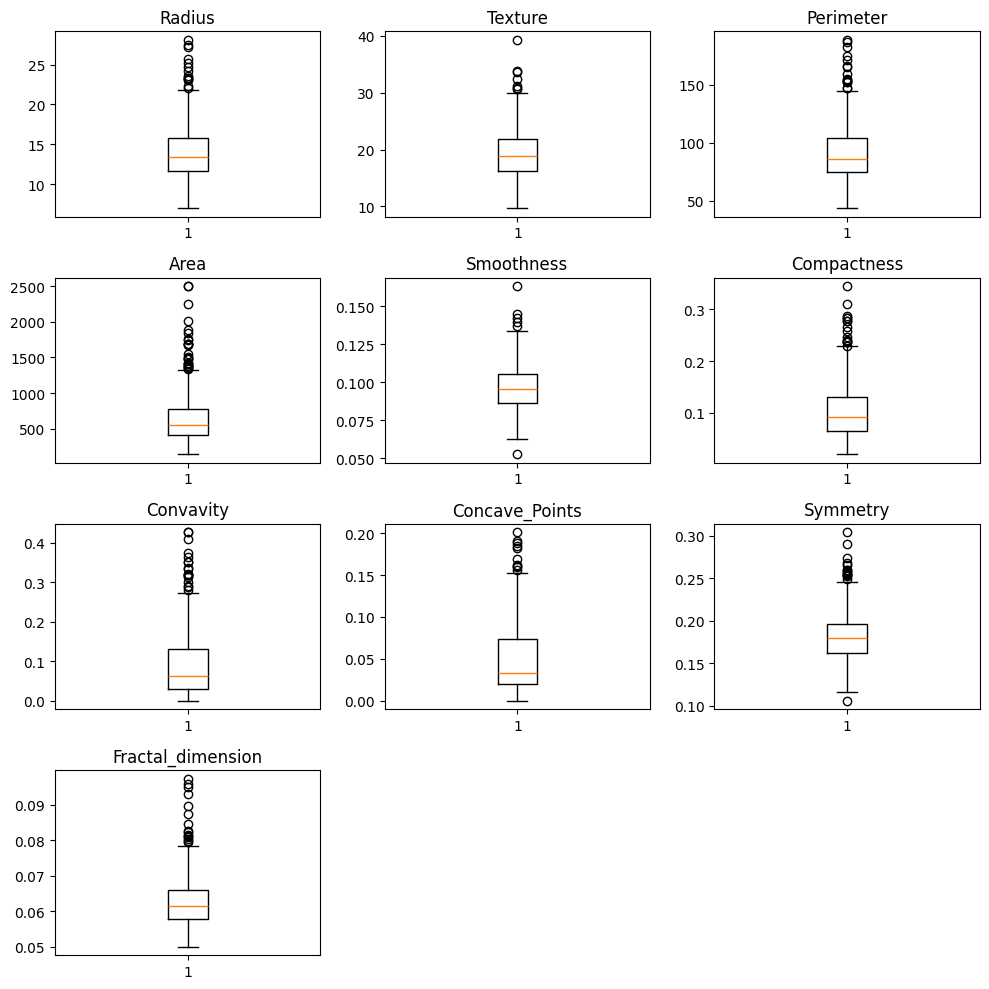

In [11]:
# Determine grid size based on the number of columns
from matplotlib import pyplot as plt  # type: ignore


num_vars = len(independant_variables)
num_rows = (num_vars // 3) + (num_vars % 3 > 0)  # Number of rows needed
num_cols = min(3, num_vars)  # Number of columns per row

# Create the figure
fig = plt.figure(figsize=(10, 10))

for id, column in enumerate(independant_variables):
    ax = plt.subplot(num_rows, num_cols, id + 1)  # Create subplot
    
    # Check if the column exists in the dataset
    if column in dataset.columns:
        # Remove null values and plot
        data = dataset[column].dropna()
        if not data.empty:  # Check if there's data to plot
            ax.boxplot(data)
        else:
            ax.text(0.5, 0.5, 'No data', horizontalalignment='center', verticalalignment='center')
        
        ax.set_title(column)
    else:
        ax.text(0.5, 0.5, 'Column not found', horizontalalignment='center', verticalalignment='center')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


Check for outliers in one

<Axes: >

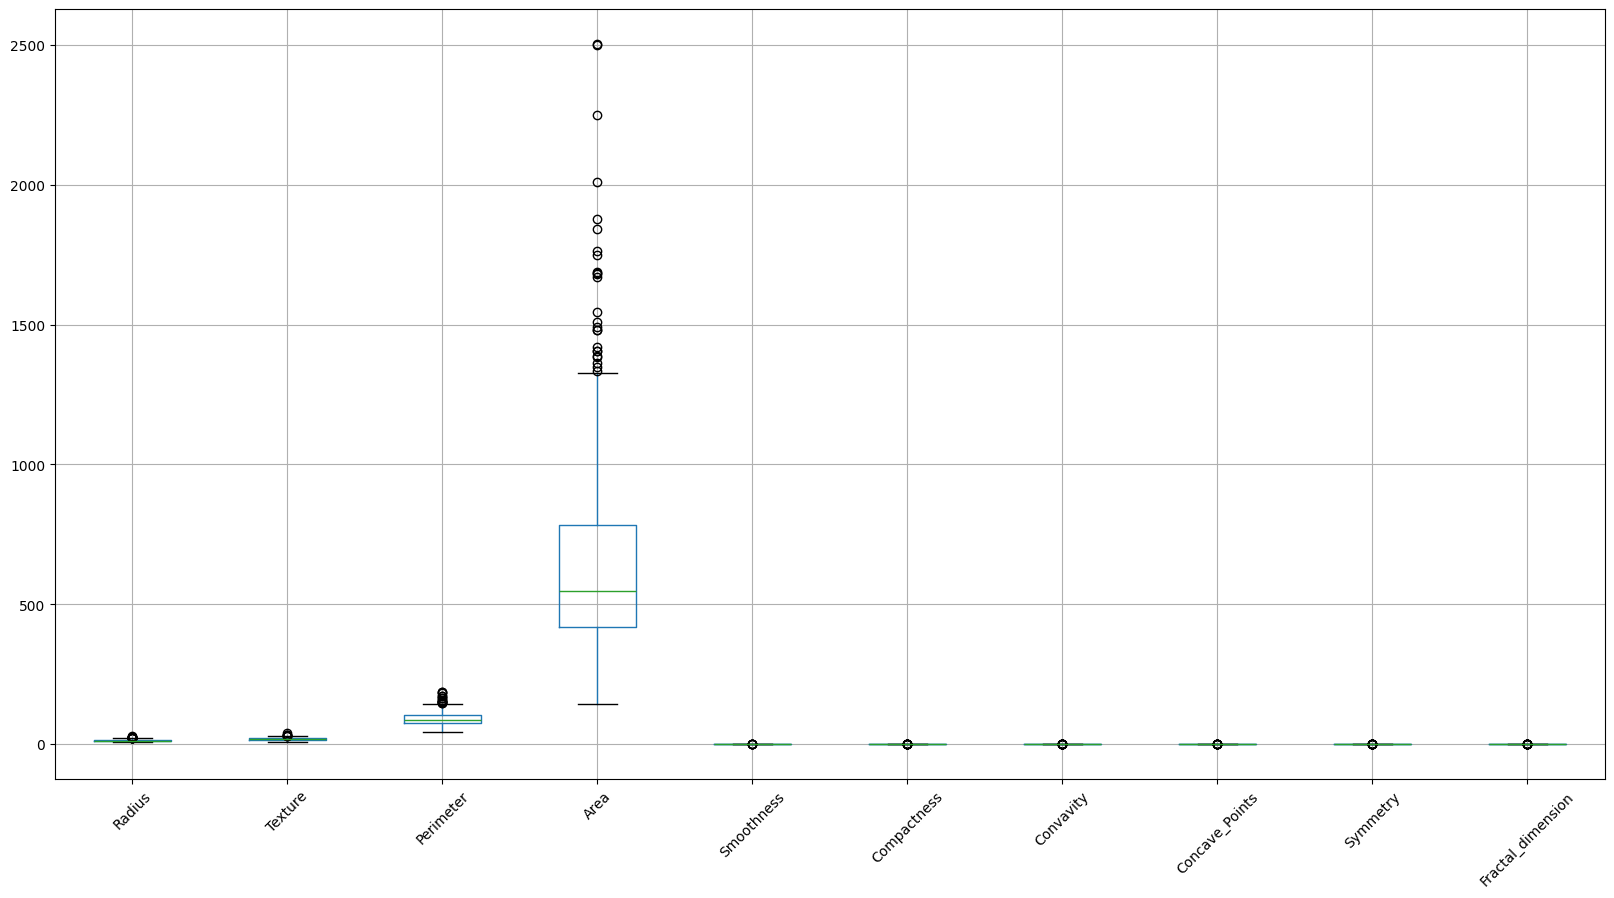

In [12]:
dataset_reduced.boxplot(column= ['Radius',  'Texture', 'Perimeter', 'Area'  
                    , 'Smoothness', 'Compactness', 'Convavity', 'Concave_Points', 'Symmetry', 'Fractal_dimension'], rot=45, figsize=(20, 10))

Check for duplicates

In [13]:
# Check dataset in a data frame 
dataset_reduced.duplicated().sum()

0

Working with outliers: Correcting & Removing

In [14]:
# Select only numeric columns
dataset_reduced_outliers = dataset_reduced.drop(columns=['ID']).select_dtypes(include='number')

# Calculate IQR  
Q1 = dataset_reduced_outliers.quantile(0.25) 
Q3 = dataset_reduced_outliers.quantile(0.75)
 
IQR = Q3 - Q1 
 
print("IQR (InterQuartile Range) for each column:")
print(IQR)

IQR (InterQuartile Range) for each column:
Radius                 4.082500
Texture                5.625000
Perimeter             28.740000
Area                 362.450000
Smoothness             0.019010
Compactness            0.065585
Convavity              0.100110
Concave_Points         0.053420
Symmetry               0.033725
Fractal_dimension      0.008422
dtype: float64


Check for missing values

In [15]:
dataset_reduced.isnull().sum()

ID                   0
Diagnosis            0
Radius               0
Texture              0
Perimeter            0
Area                 0
Smoothness           0
Compactness          0
Convavity            0
Concave_Points       0
Symmetry             0
Fractal_dimension    0
dtype: int64

Distribution plots

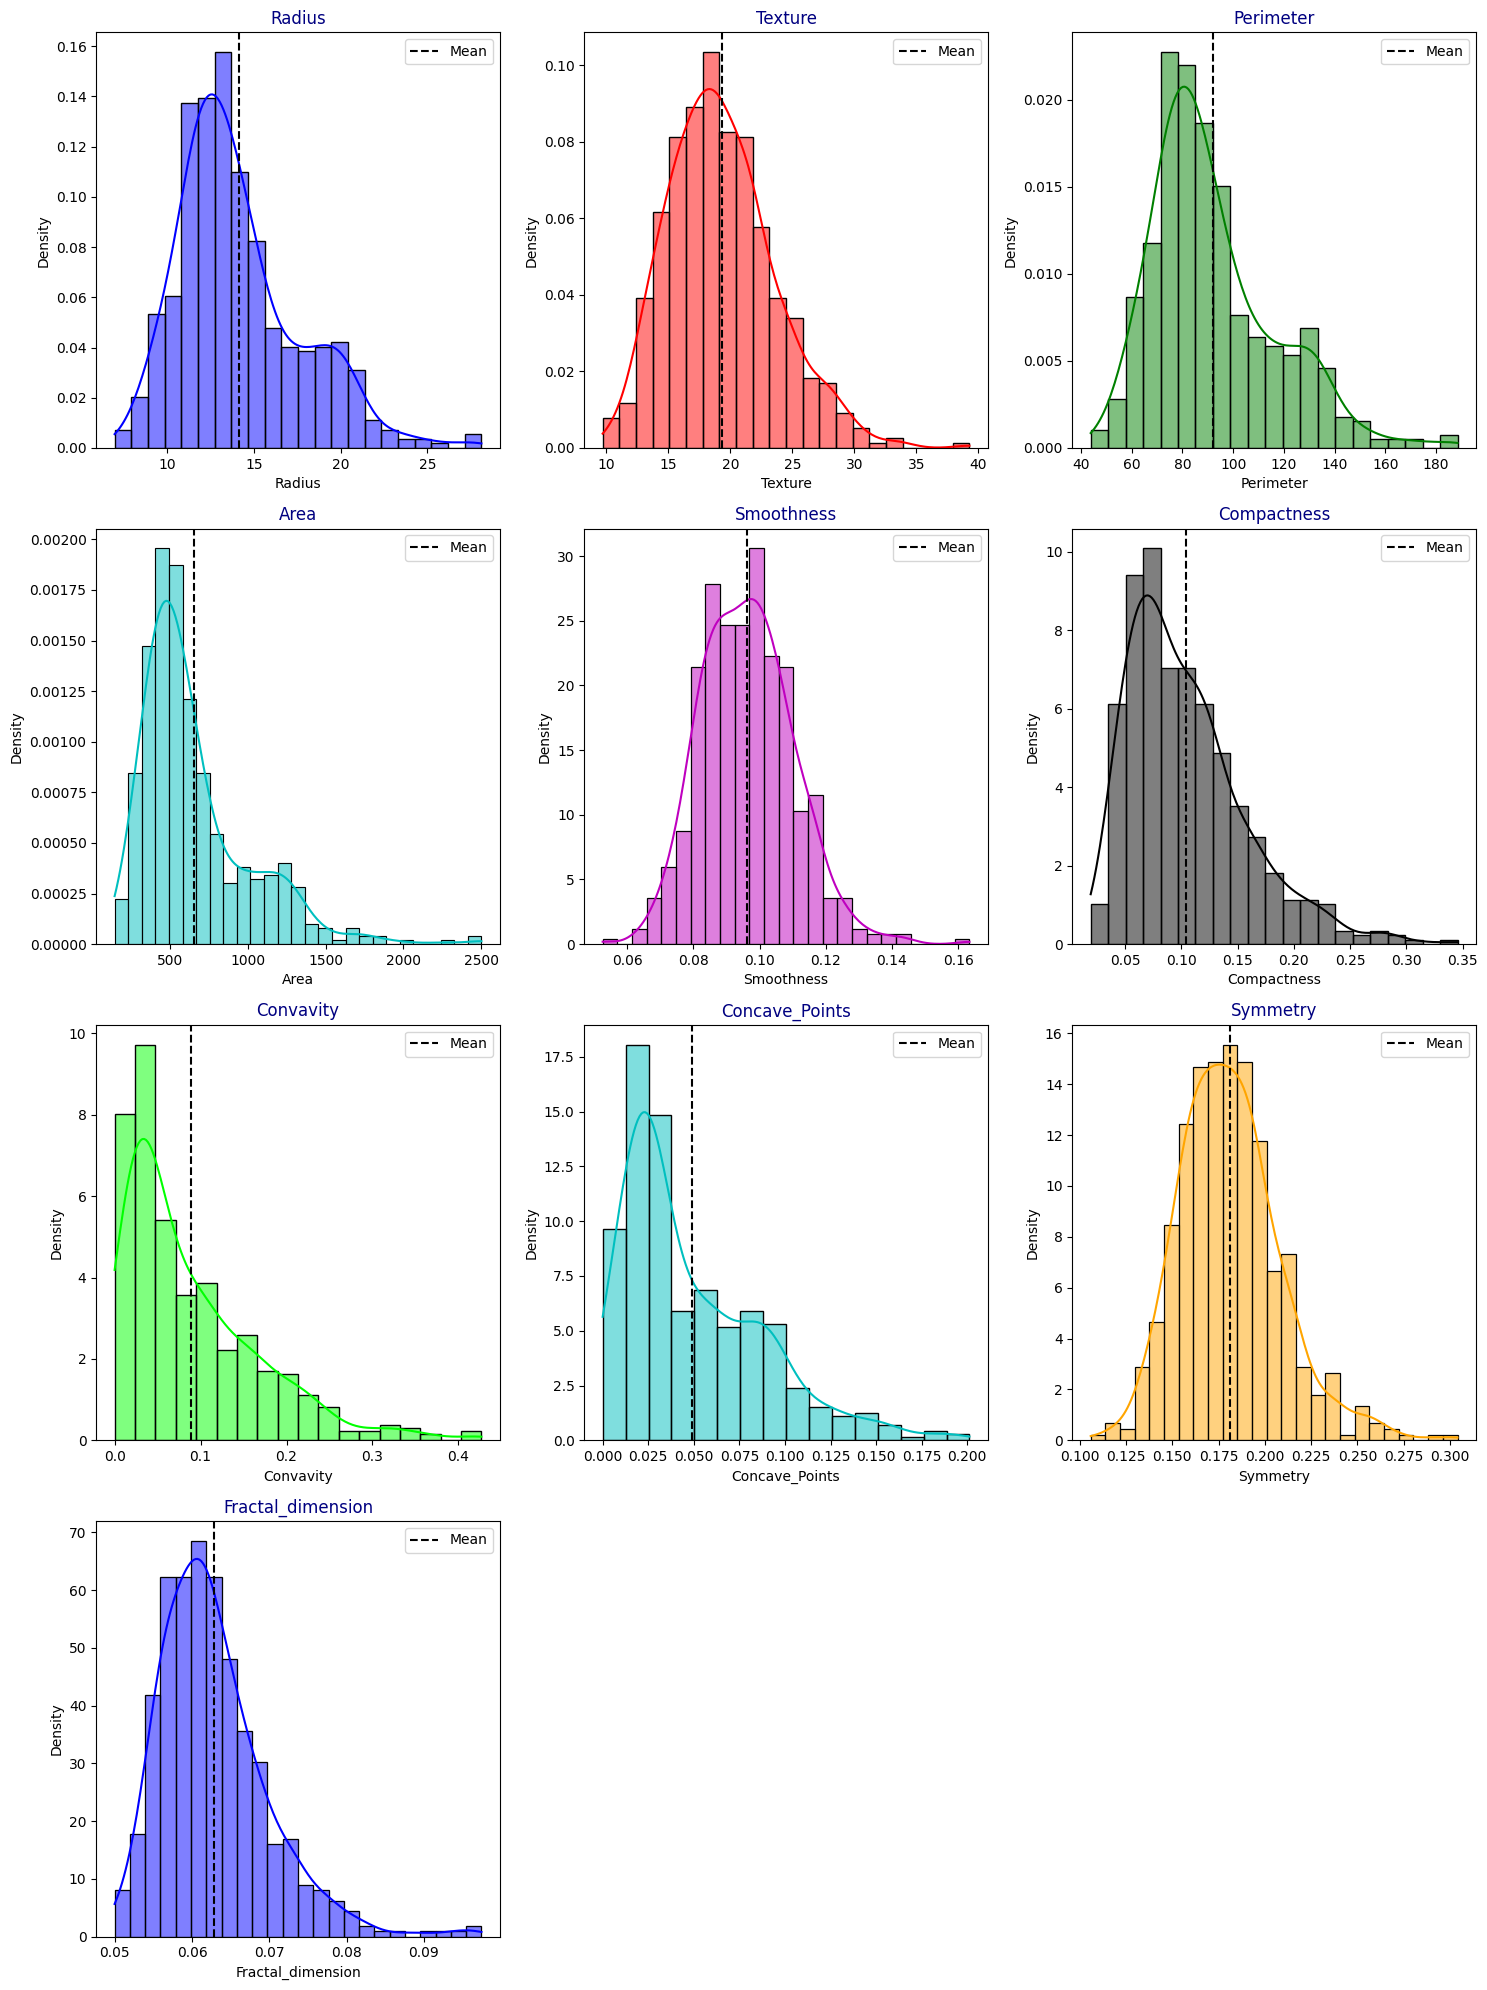

In [16]:
import itertools
import seaborn as sns # type: ignore
import matplotlib.pyplot as plt # type: ignore

cols = [i for i in dataset_reduced.columns if i not in ['ID', 'Diagnosis']]
length = len(cols)
cs = ["b", "r", "g", "c", "m", "k", "lime", "c", "orange"]  # Add color for additional plots

# Calculate number of rows and columns needed
num_rows = (length // 3) + (length % 3 > 0)
num_cols = min(3, length)  # Adjust number of columns per row

fig = plt.figure(figsize=(15, num_rows * 5))  # Adjust figure size accordingly

for i, (col, color) in enumerate(zip(cols, itertools.cycle(cs))):
    ax = plt.subplot(num_rows, num_cols, i + 1)
    sns.histplot(dataset_reduced[col], color=color, stat="density", kde=True)
    plt.axvline(dataset_reduced[col].mean(), linestyle="dashed", label="Mean", color="k")
    plt.legend(loc="best")
    plt.title(col, color="navy")
    plt.xlabel(col)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


Summary statistics for each variable

In [17]:
# Drop the 'ID' column 
dataset_summary = dataset_reduced.drop(columns=['ID']) 
 
# Get the summary statistics and transpose the result 
summary_statistics = dataset_summary.describe().T 
 
print(summary_statistics)

                   count        mean         std        min         25%  \
Radius             568.0   14.120491    3.523416    6.98100   11.697500   
Texture            568.0   19.305335    4.288506    9.71000   16.177500   
Perimeter          568.0   91.914754   24.285848   43.79000   75.135000   
Area               568.0  654.279754  351.923751  143.50000  420.175000   
Smoothness         568.0    0.096321    0.014046    0.05263    0.086290   
Compactness        568.0    0.104036    0.052355    0.01938    0.064815   
Convavity          568.0    0.088427    0.079294    0.00000    0.029540   
Concave_Points     568.0    0.048746    0.038617    0.00000    0.020310   
Symmetry           568.0    0.181055    0.027319    0.10600    0.161900   
Fractal_dimension  568.0    0.062770    0.007035    0.04996    0.057697   

                          50%         75%         max  
Radius              13.355000   15.780000    28.11000  
Texture             18.855000   21.802500    39.28000  
Perime

Multivariate analysis

In [18]:
sns.pairplot(dataset, diag_kind= 'kde', corner=True)

Investigate the correlation between each variable

In [19]:
# Select only numeric columns
numeric_data = dataset_reduced.select_dtypes(include=['number'])

# Compute the correlation matrix
corr_matrix = numeric_data.corr()

# Output the correlation matrix
print("Correlation matrix:")
print(corr_matrix)

Correlation matrix:
                         ID    Radius   Texture  Perimeter      Area  \
ID                 1.000000  0.075166  0.099288   0.073796  0.097390   
Radius             0.075166  1.000000  0.329383   0.997876  0.987344   
Texture            0.099288  0.329383  1.000000   0.335918  0.326193   
Perimeter          0.073796  0.997876  0.335918   1.000000  0.986548   
Area               0.097390  0.987344  0.326193   0.986548  1.000000   
Smoothness        -0.012343  0.168094 -0.017769   0.204505  0.174838   
Compactness        0.001476  0.505129  0.252038   0.555676  0.497981   
Convavity          0.051507  0.676557  0.315248   0.715662  0.686232   
Concave_Points     0.045472  0.823165  0.305590   0.851338  0.824246   
Symmetry          -0.021284  0.144236  0.080146   0.179100  0.148219   
Fractal_dimension -0.051808 -0.317749 -0.068771  -0.268103 -0.288560   

                   Smoothness  Compactness  Convavity  Concave_Points  \
ID                  -0.012343     0.001476

Conclusion  
- The dataset consist of diagnostic measures for breast cancer, which is crucial to predicting the diagnosis (malignant or belign) 
- Univariate analysis using boxplots and histograms provides insight into the distribution and central tendancy for each feature  
- Variables like Radius, Perimeter, and Area exhibit significant variations, as indicated by their high standard deviations.
- The correlation matrix reveals strong positive correlations between features like Radius, Perimeter, and Area, indicating multicollinearity, which occurs when two or more independant vairables have a high correlation with one another in a regression model 
- Strong correlations between certain variables can indicate multicollinearity, which may need to be addressed in predictive modeling. 
- No missing values in the dataset  
- Pairplots and the correlation matrix help in understanding the relationships between different diagnostic measures. 
- Identifying the most influential features for predicting the diagnosis is crucial. Features with high variance and strong correlations to the target variable are likely candidates.